## Its a trial to demonstrate the Quantum Tomography
Preparing Environment


In [3]:
from scipy.linalg import expm
from scipy.sparse.linalg import eigsh
import numpy as np
import dataset
import pickle

In [2]:
# save states

N = 9
T = 1
J_list = [1]
h_list = [0, 0.2, 0.4, 0.6, 0.8, 1]

for h in h_list:
    ising_hamiltonian = dataset.IsingHamiltonian(n_qubits = N, J=J_list[0], h=h)

    simulator = dataset.GibbsStateSimulator(ising_hamiltonian)

    # Simulate the Gibbs state over a temperature range
    gibbs_states = simulator.simulate_temperature_scan(1, 2, 1)

    filename = f'gibbs_dataset/gibbs_ising_nq{N}_T{T}_h{h}'
    simulator.save_gibbs_states_to_pkl(gibbs_states, filename)



Gibbs states saved to gibbs_dataset/gibbs_ising_nq9_T1_h0
Gibbs states saved to gibbs_dataset/gibbs_ising_nq9_T1_h0.2
Gibbs states saved to gibbs_dataset/gibbs_ising_nq9_T1_h0.4
Gibbs states saved to gibbs_dataset/gibbs_ising_nq9_T1_h0.6
Gibbs states saved to gibbs_dataset/gibbs_ising_nq9_T1_h0.8
Gibbs states saved to gibbs_dataset/gibbs_ising_nq9_T1_h1


In [3]:
gibbs_states_allh = []
for idx in h_list:

    filename = f'gibbs_dataset/gibbs_ising_nq{N}_T{T}_h{h}'
    
    with open(filename, "rb") as f:
        gibbs_states = pickle.load(f)
        gibbs_states_allh.append(gibbs_states_allh)

### Local pauli term $<\sigma_1^z \sigma_j^z>$, $1 < j \leq N$

In [4]:
for idx in h_list:
    # load gibbs state
    filename = f'gibbs_dataset/gibbs_ising_nq{N}_T{T}_h{idx}'
    
    with open(filename, "rb") as f:
        gibbs_states = pickle.load(f)
        gibbs_states = gibbs_states[1]

    # obs
    corr_term_each_h = []
    for j in range(1, N):
        obs =  [dataset.Z] +  [dataset.I] * (N - 1)
        obs[j] = dataset.Z
        zz_obs = dataset.kron_n(obs)

        # calulate correlation term
        corr_term = np.trace(gibbs_states * zz_obs)
        corr_term_each_h.append(corr_term)
    
    print(corr_term_each_h)
    fn = f'correlation/gibbs_ising_nq{N}_T{T}_h{idx}_Z'
    np.save(fn, corr_term_each_h)
    

[np.complex128(0.761594155955765+0j), np.complex128(0.580025658385974+0j), np.complex128(0.44174415173115256+0j), np.complex128(0.3364297643860825+0j), np.complex128(0.25622294244601534+0j), np.complex128(0.19513789558867556+0j), np.complex128(0.14861588088584157+0j), np.complex128(0.11318498636487503+0j)]
[np.complex128(0.7499873170410598+0j), np.complex128(0.5678001211524051+0j), np.complex128(0.4298795255472735+0j), np.complex128(0.325460340252161+0j), np.complex128(0.2464049269672003+0j), np.complex128(0.18655233502953183+0j), np.complex128(0.14123700306991524+0j), np.complex128(0.10666513619307885+0j)]
[np.complex128(0.7167069393747806+0j), np.complex128(0.5328956395114863+0j), np.complex128(0.3963637304379151+0j), np.complex128(0.29481372048947907+0j), np.complex128(0.2192812495530531+0j), np.complex128(0.163100271673886+0j), np.complex128(0.12129927235835795+0j), np.complex128(0.08938034847455618+0j)]
[np.complex128(0.6660402688081196+0j), np.complex128(0.48024430945537044+0j), 

In [5]:
import numpy as np
from collections import Counter
import json

# Define Pauli matrices
I = np.eye(2)
Z = np.array([[1, 0], [0, -1]])

# System parameters
J = 1.0  # Coupling strength
h = 0.0  # Transverse field
beta = 0.9  # Inverse temperature
L = 4  # Number of spins

# Construct the Hamiltonian (Ising model)
H = np.zeros((2**L, 2**L))
for i in range(L - 1):
    Z_i = np.kron(np.kron(np.eye(2**i), np.kron(Z, Z)), np.eye(2**(L - i - 2)))
    H -= J * Z_i
for i in range(L):
    X_i = np.kron(np.kron(np.eye(2**i), np.array([[0, 1], [1, 0]])), np.eye(2**(L - i - 1)))
    H -= h * X_i

# Gibbs state
rho = expm(-beta * H)
rho /= np.trace(rho)

# Compute probabilities of all bitstrings
probs = np.diag(rho).real  # Diagonal elements represent the probabilities of each basis state
bitstrings = [format(i, f"0{L}b") for i in range(2**L)]  # Generate all possible bitstrings

# Create a dictionary for expected probabilities
expected_probs = {bitstrings[i]: probs[i] for i in range(len(bitstrings))}

# Julia sampled bitstrings
# Load the JSON file
json_file = "total_bitstring.json"
with open(json_file, "r") as file:
    julia_bitstrings = json.load(file)

# print("Loaded bitstrings:", julia_bitstrings)

# Convert Julia bitstrings to binary strings
julia_bitstrings_str = ["".join(map(str, bit)) for bit in julia_bitstrings]

# Calculate frequencies from Julia samples
julia_counts = Counter(julia_bitstrings_str)
julia_total = sum(julia_counts.values())
julia_probs = {key: value / julia_total for key, value in julia_counts.items()}

# Compare probabilities
print(f"{'Bitstring':<10} {'Julia Prob':<15} {'Expected Prob':<15} {'Difference':<15}")
for bitstring, julia_prob in julia_probs.items():
    expected_prob = expected_probs.get(bitstring, 0)
    diff = abs(julia_prob - expected_prob)
    print(f"{bitstring:<10} {julia_prob:<15.6f} {expected_prob:<15.6f} {diff:<15.6f}")


Bitstring  Julia Prob      Expected Prob   Difference     
0000       0.343000        0.315979        0.027021       
1111       0.272000        0.315979        0.043979       
0001       0.047000        0.052231        0.005231       
1110       0.044000        0.052231        0.008231       
0111       0.052000        0.052231        0.000231       
0011       0.051000        0.052231        0.001231       
0100       0.016000        0.008634        0.007366       
1000       0.060000        0.052231        0.007769       
1011       0.006000        0.008634        0.002634       
1100       0.054000        0.052231        0.001769       
1001       0.018000        0.008634        0.009366       
1101       0.010000        0.008634        0.001366       
0110       0.009000        0.008634        0.000366       
0010       0.016000        0.008634        0.007366       
0101       0.002000        0.001427        0.000573       


d:\acdemic_software\anaconda\envs\qiskit-env\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\acdemic_software\anaconda\envs\qiskit-env\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


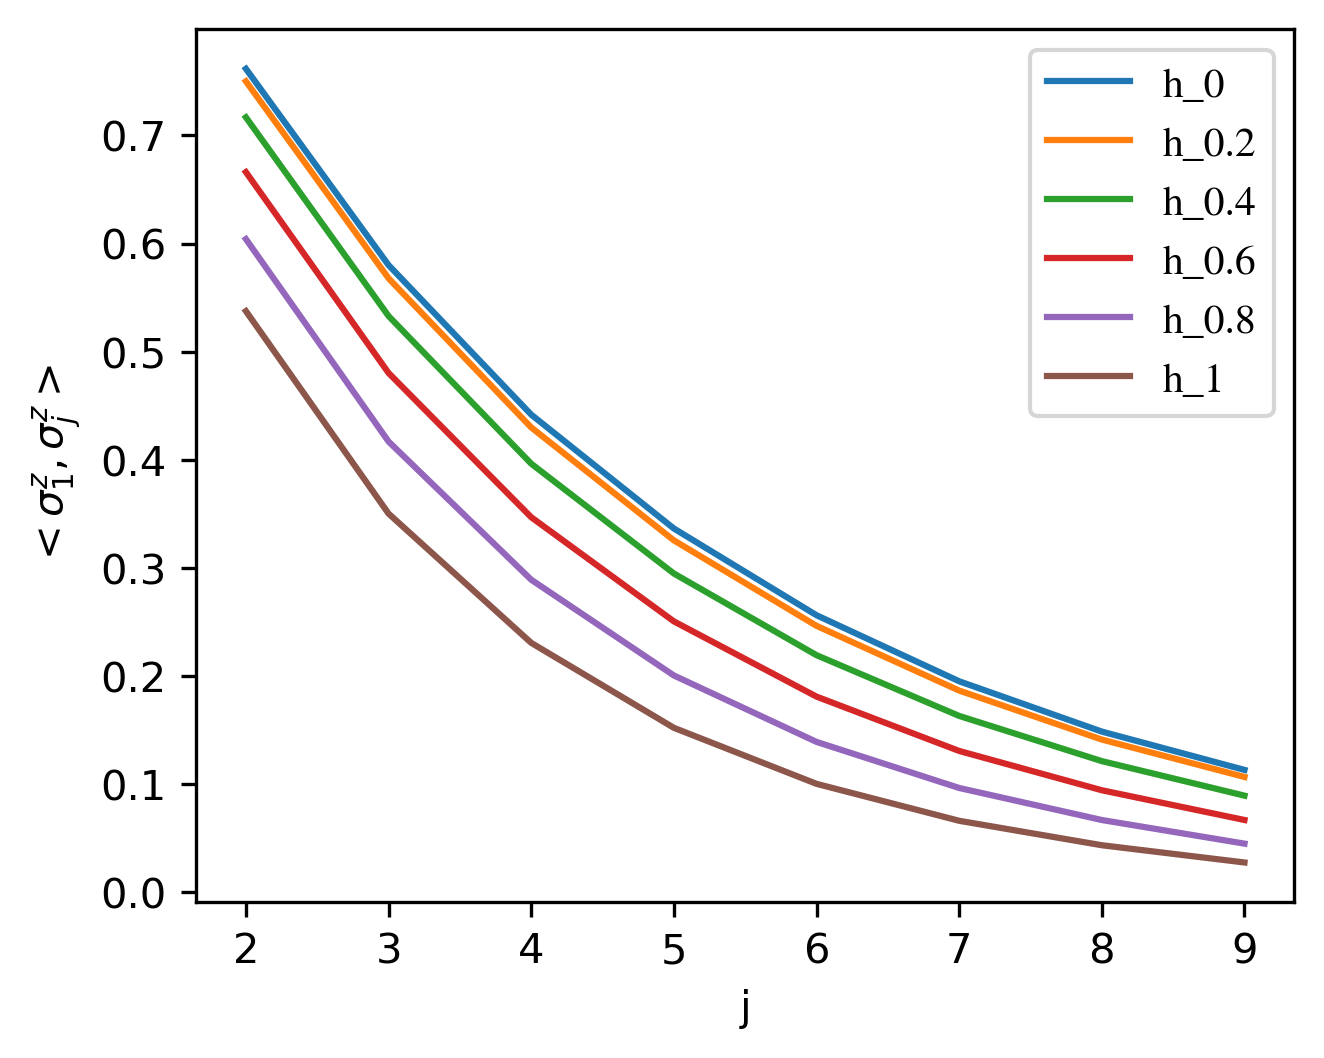

In [6]:
# define figure size
import matplotlib.pyplot as plt
centimeter_to_inch = 1 / 2.54
figure_width = centimeter_to_inch * 12
figure_height = figure_width * 0.8
fig = plt.figure(figsize=(figure_width, figure_height), dpi=300)  # size in inches
ax = fig.add_subplot(1, 1, 1)

# set all fonts
font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family

# set ticks in
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# font size
font_size_name_xy = 30
font_size_tick_label = 26
font_size_legend = 16
font_xy = {'family': font_family, 'size': font_size_name_xy}
font_legend = {'family': font_family, 'size': font_size_legend}

for idx in h_list:
    fn = f'correlation/gibbs_ising_nq{N}_T{T}_h{idx}_Z.npy'
    corr_term = np.load(fn)

    plt.plot(range(2,N+1), corr_term, label=f'h_{idx}')
    plt.ylabel(r'$<\sigma_1^z, \sigma_j^z>$')
    plt.xlabel("j")

plt.legend()


### Renyi entropy with order 2

#S_A for A=[1,2...,i], where 1<= i <N